# Unsupervised Non-negative Matrix Factorization (NMF) for BBC News Classifcation

## Imports

In [1]:
# Comment out below line if only interested in NMF
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 31.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 68.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 31.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.2 MB/s eta 0:00:0000:01:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-bert:

In [114]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn import preprocessing 
import itertools
from sklearn.model_selection import train_test_split

# Comment out below lines if ony interested in NMF
import ktrain
from ktrain import text
from ktrain.text import texts_from_df
from transformers import AutoTokenizer, TextClassificationPipeline
import time

## Loading Data

In [115]:
train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

## Exploratory Data Analysis (EDA)

In [116]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [117]:
train.shape

(1490, 3)

In [118]:
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [119]:
test.shape

(735, 2)

The training set has 1490 articles and the test set 735 articles with corresponding text of each article included as the only predictive feature. The training set contains an additional "Category" field which is the topic category of the article and is the target variable we aim to predict for the test set.

We investigate the counts of the various categories in the training data.


Text(0, 0.5, 'Count')

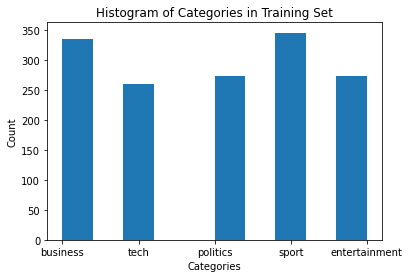

In [120]:
plt.hist(train['Category']),
plt.title('Histogram of Categories in Training Set')
plt.xlabel('Categories')
plt.ylabel('Count')

The training set is relatively balanced across categories.

Next we investigate how long the texts are in each article in the training set and test set.

Text(0, 0.5, 'Count')

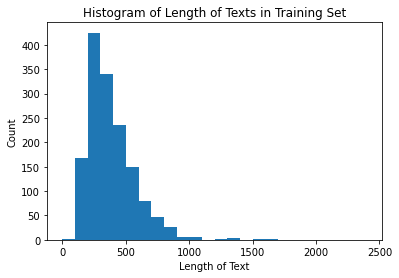

In [121]:
plt.hist([len(i.split()) for i in train['Text']], 
          bins = range(0,2500,100))
plt.title('Histogram of Length of Texts in Training Set')
plt.xlabel('Length of Text')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

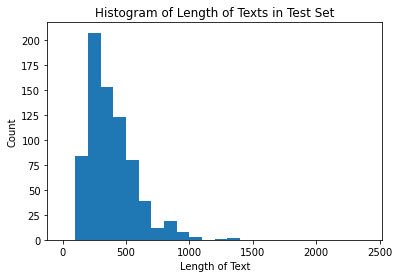

In [122]:
plt.hist([len(i.split()) for i in test['Text']], 
          bins = range(0,2500,100))
plt.title('Histogram of Length of Texts in Test Set')
plt.xlabel('Length of Text')
plt.ylabel('Count')

The distributions are fairly similar with some especially lengthy articles that could be considered outliers.

The below commented out code can be used to restrict analysis of the articles to a fixed length determined by the "max_len" variable. However after experimenting with a few different values, there was no improvement in performance over using the full articles. 

In [123]:
# max_len = 300
# train['Text'] = [' '.join(i.split()[:max_len]) for i in train['Text'].tolist()]

Next we investigate how many unique words are there in the training set.

In [124]:
len(pd.Series(' '.join(train['Text']).lower().split()).value_counts())

35594

The most common words in the training set are likely not to have much predictive value in determining which topic category an article belongs to as shown below.


In [125]:
pd.Series(' '.join(train['Text']).lower().split()).value_counts()[:10]

the     34992
to      16568
of      12970
and     12366
a       12102
in      11696
s        5899
for      5773
is       5478
that     5207
dtype: int64

Stop words are common words which do not have much predictive power and are removed in NLP tasks. After they are removed we can investigate again the most common words.


In [126]:
stop = stopwords.words('english')
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [127]:
words = ' '.join(train['Text']).lower().split()
len(pd.Series([word for word in words if word not in stop]).value_counts())

35448

In [128]:
pd.Series([word for word in words if word not in stop]).value_counts()[:10]

said      3401
-         2125
mr        1969
would     1710
also      1424
new       1329
people    1277
us        1138
one       1125
could     1031
dtype: int64

146 stop words have been removed. There is a slight improvement in the most common words but the result is hardly satisfactory. In addition to removing stop words, finding words that are particularly unique to an article relative to others will help differentiate articles of distinct categories. This is what term frequency - inverse document frequency aims to do.

## Text Preprocessing Via Term Frequencey - Inverse Document Frequency (TF-IDF)


Term frequency (tf) is determined by counting the number of times a term appears in a document and dividing it by the total number of terms in the document, with repeat occurrences of all terms each counted separately. It signifies the importance of a term in a document.

Inverse document frequency (idf) helps mitigate the effect of words popular across documents from having too much importance. For the sklearn implementation of idf that will be used here, it is determined by the log of the number of documents in the data set divided by the number of documents containing that term, plus one (to give terms appearing in all documents some weight).

Tf-idf multiplies the term frequency by the inverse document frequency so that both above factors are considered and high tf-idf scores for a given document implies the words are somewhat common in that document but not particularly common across other documents.

Sklearn's TfidfVectorizer is utilized to calculate tf-idf on the training data with stop words removed and only words appearing in at least five articles are kept, to reduce noise. The testing data is not used to calculate tf-idf as in reality, any robust model should be able to perform well on words that are not seen by the model. 


In [129]:
vect = TfidfVectorizer(min_df = 5, stop_words='english')
X = vect.fit_transform(train['Text'])

In [130]:
X.shape

(1490, 7115)

The pruning described above has reduced the number of words under consideration to 7115, which is about 20% of the intial unique word list in the training data.

Now we can take a look at the words with the highest tf-idf scores in each article to get an understanding of the matrix $X$.

In [131]:
tfidf = pd.DataFrame(X.toarray(), columns = vect.get_feature_names())
pd.Series(tfidf.idxmax(axis=1)).value_counts()

best            15
brown           11
festival        10
music           10
film             9
                ..
collection       1
broadcasters     1
stadium          1
cards            1
reuters          1
Length: 852, dtype: int64

These are quite descriptive and illustrate the power of tf-idf in text processing. 

## Non-negative Matrix Factorization (NMF) Modeling

Non-negative matrix factorization (NMF) is an unsupervised learning technique that via linear algebra and dimension reduction, aims to learn latent components. Even though our training data set has "Category" labels, using unsupervised learning to find five distinct categories through the tf-idf matrix previously constructed, the categories ideally will overlap heavily with the known labels. 

Let us check if the tf-idf matrix is appropriate for NMF by ensuring all values are non-negative. Based on its construction it should be.

In [132]:
np.min(X.toarray())

0.0

Except for specifying the number of components to match our set of target categories, default parameters are used.

In [133]:
model = NMF(n_components=5, random_state=0)
W = model.fit_transform(X)
H = model.components_

$W \cdot H$ approximates the tf-idf matrix $X$. Note $W$ encodes information about the articles and latent dimensions whereas $H$ encodes information about the words and latent dimensions.

In [134]:
H.shape

(5, 7115)

From $H$, the largest values in each row can be used to determine words of significance for each of the five latent dimensions.

In [135]:
for idx, topic in enumerate(H):
    top_features_ind = topic.argsort()[: -6 : -1]
    top_features = [vect.get_feature_names()[i] for i in top_features_ind]
    print(idx, top_features)

0 ['england', 'game', 'win', 'wales', 'cup']
1 ['mr', 'labour', 'election', 'blair', 'brown']
2 ['mobile', 'people', 'music', 'said', 'phone']
3 ['film', 'best', 'awards', 'award', 'actor']
4 ['growth', 'said', 'economy', 'year', 'sales']


In [136]:
train['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

Looking at the most significant words for each of the five latent dimensions, it appears topic 0 is sport, topic 1 is politics, topic 2 is tech, topic 3 is entertainment and topic 4 is business. The model seems to have differentiated the categories as required.

In [137]:
W.shape

(1490, 5)

In [138]:
W[:5]

array([[0.        , 0.03995917, 0.00695288, 0.00348418, 0.05304083],
       [0.        , 0.        , 0.        , 0.        , 0.21554571],
       [0.01468196, 0.02434222, 0.02649972, 0.00092671, 0.11811285],
       [0.        , 0.        , 0.23018997, 0.        , 0.        ],
       [0.00478869, 0.00470102, 0.00828843, 0.00840267, 0.07742818]])

From $W$, the largest values in each row can be used to determine the latent dimension that each article is most strongly associated with.

In [139]:
pred_train = np.argmax(W, axis = 1)
pred_train

array([4, 4, 4, ..., 4, 2, 2])

Without inspection of the significant words for each topic, the predictions generated by finding the column with the largest value in matrix $W$ merely return numerical values.  To assign these numerical values to the appropriate categories, the labels are permuted and compared to the training set categories, with the maximum accuracy determining the assignment. 


In [140]:
le = preprocessing.LabelEncoder()

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    
    best_perm = 0
    acc = 0

    for i in itertools.permutations([j for j in range(n)], n):
        yp_new = [i[k] for k in yp]
        ytdf_num = le.fit_transform(ytdf)
        acc_try = np.mean([ytdf_num == yp_new])
        if acc_try > acc:
            acc = acc_try
            best_perm = i
    
    return best_perm, acc 

In [141]:
labelorder, acc = label_permute_compare(train['Category'], pred_train)
print(labelorder, acc)

(3, 2, 4, 1, 0) 0.9187919463087248


The above permutation results in the highest accuracy on the training set: 0.919 (3 s.f.)

Using the permutation and reversing the label encoder, the category predictions can be recovered, which will be required to submit predictions to determine the test set accuracy.

In [142]:
pred_train_ordered = np.array(labelorder)[pred_train]
le.fit_transform(train['Category'])
pred_train_string = le.inverse_transform(pred_train_ordered)
pred_train_string[:10]

array(['business', 'business', 'business', 'tech', 'business', 'politics',
       'sport', 'entertainment', 'business', 'entertainment'],
      dtype=object)

The accuracy can be checked to see if it matches the label permutation function with text strings.

In [143]:
np.mean(pred_train_string == train['Category'])

0.9187919463087248

The result is as expected. 

Having observed the workflow once, we construct a helper function for calculating the training accuracy for future combinations of hyper-parameters.


In [144]:
def nmf_acc_train(min_df, max_df = 1.0, n_comp = 5, solver='cd', beta_loss='frobenius'):
    vect = TfidfVectorizer(min_df     = min_df, 
                           max_df     = max_df, 
                           stop_words ='english')
    
    X = vect.fit_transform(train['Text'])
    model = NMF(n_components=n_comp, 
                random_state=0, 
                solver = solver, 
                beta_loss = beta_loss)
    
    W = model.fit_transform(X)
    pred_train = np.argmax(W, axis = 1)
    labelorder, acc = label_permute_compare(train['Category'], pred_train)
    return labelorder, acc

nmf_acc_train(min_df = 5)

((3, 2, 4, 1, 0), 0.9187919463087248)

The function works as expected.

In [35]:
from itertools import product

for min_df, max_df in product([2,5,10], [0.9,0.95,1.0]):
    print(min_df, max_df, nmf_acc_train(min_df=min_df,max_df=max_df))

2 0.9 ((3, 2, 4, 1, 0), 0.9194630872483222)
2 0.95 ((3, 2, 4, 1, 0), 0.9194630872483222)
2 1.0 ((3, 2, 4, 1, 0), 0.9194630872483222)
5 0.9 ((3, 2, 4, 1, 0), 0.9187919463087248)
5 0.95 ((3, 2, 4, 1, 0), 0.9187919463087248)
5 1.0 ((3, 2, 4, 1, 0), 0.9187919463087248)
10 0.9 ((3, 2, 4, 1, 0), 0.9154362416107382)
10 0.95 ((3, 2, 4, 1, 0), 0.9154362416107382)
10 1.0 ((3, 2, 4, 1, 0), 0.9154362416107382)


There is not much variation with "max_df" having no effect as stop words appear to have removed words common across articles. The test set accuracy for "min_df" of 2, 5 and 10 will be reported later with "max_df" kept at default 1.0.

Now let us generate the predictions on the test set with a helper function that mimics the training accuracy helper function and conversion of training predicted labels to strings, but here the vectorizer and model are not fitted but transformed using fits on the training set.

In [145]:
def nmf_test_preds(vect, model, labelorder, df_text):
    X_test = vect.transform(df_text)
    W_test = model.transform(X_test)
    pred_test = np.argmax(W_test, axis = 1)
    pred_test_ordered = np.array(labelorder)[pred_test]
    pred_test_string = le.inverse_transform(pred_test_ordered)
    return pred_test_string

vect = TfidfVectorizer(min_df = 5, stop_words='english')
X = vect.fit_transform(train['Text'])
model = NMF(n_components=5, random_state=0)
W = model.fit_transform(X)

# labelorder determined after running and inspecting output of nmf_acc_train() but prior variable
# passed here.

labelorder = labelorder
nmf_test_preds(vect, model, labelorder, test['Text'])[:10]

array(['sport', 'tech', 'sport', 'business', 'sport', 'sport', 'politics',
       'politics', 'entertainment', 'business'], dtype=object)

The above shows the workflow with the training steps re-run to determine the first ten predictions on the test set.

Let us get some better understanding of the tf-idf matrix again to see where improvements to the model can be made.

In [146]:
np.mean(X.toarray())

0.001220961203473605

The very low mean value suggests that KL loss should be used instead of Frobenius as the matrix $X$ should be modelled as a Poisson random variable instead of Gaussian (for which low values may become negative).

In [38]:
for min_df in [2,5,10]:
    print(min_df, nmf_acc_train(min_df=min_df, 
                  solver='mu', 
                  beta_loss='kullback-leibler'))

2 ((3, 2, 4, 1, 0), 0.9436241610738255)
5 ((3, 2, 4, 1, 0), 0.9355704697986578)
10 ((3, 2, 4, 1, 0), 0.9248322147651007)


The training accuracies are indeed higher. Test accuracy of min_df for all three instances will be reported. We will construct the submission file with "min_df" = 2 and KL loss as it has the highest accuracy on the training set. For best practices to avoid overfitting when hyper-paramater tuning a validation set could have been constructed but as we shall see later the testing accuracy is in line with training accuracy in all instances.

In [147]:
vect = TfidfVectorizer(min_df = 2, stop_words='english')
X = vect.fit_transform(train['Text'])
model = NMF(n_components=5, 
            random_state=0,
            solver='mu', 
            beta_loss='kullback-leibler')

W = model.fit_transform(X)
labelorder = labelorder
nmf_test_preds(vect, model, labelorder, test['Text'])[:10]

array(['sport', 'tech', 'sport', 'business', 'sport', 'sport', 'politics',
       'politics', 'entertainment', 'business'], dtype=object)

In [148]:
sub = test.copy()
sub['Category'] = nmf_test_preds(vect, model, labelorder, test['Text'])
sub.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


In [41]:
sub.drop(columns = 'Text', inplace = True)
sub.to_csv('submission_nmf.csv', index=False)
# Comment out below if wish to use supervised approach for automatic notebook submission
sub.to_csv('submission.csv', index=False)

## Results

|Min_df|Loss|Train accuracy (3 s.f.)| Test accuracy (3 s.f.)| 
|:----|:--------|:--------|:--------:|
|2|Frobenius|0.919|0.925|
|5|Frobenius|0.919|0.929|
|10|Frobenius|0.915|0.917|
|2|KL|0.944|0.943|
|5|KL|0.936|0.933|
|10|KL|0.925|0.922|

None of the models overfit with KL loss generally performing better with min_df = 2 achieving a test accuracy of 0.943 (3 s.f.) In addition to the above, the article maximum length was pruned and "max_features and "max_df" were changed but all combinations saw no change or worse results. The "ngram_range" parameter was increased to consider bigrams (pairs of words instead of individual words) but five fairly diverse topic categories, significant unigrams identified by tf-idf were predictive enough that bigrams did not add predictive power.

##  Supervised Learning Approach Comparison: Transformer Models

For supervised learning, we make use of DistilBERT which is a lightweight version of Google's famous pre-trained BERT language transformer model. Enabling GPU is recommended for reasonable training and inference times. Note without GPU the entire previous NMF portion of this notebook was able to run in under one minute.  The initial workflow below follows Dr. Vargo's colab notebook (see references) from University of Colorado Boulder's Coursera course on Supervised Text Classification.  

In [74]:
target_names = ['business', 'tech', 'politics', 'sport', 'entertainment']

Transformer models are quite memory intensive and while experimenting with hyper-parameters, led to Kaggle occasionally crashing. Thus the "maxlen" parameter is set to 200 so only the first 200 words per article will be considered.

In [75]:
# Need to re-run below if need to reset the transformer:
from ktrain import text

t = text.Transformer('distilbert-base-uncased', maxlen=200, class_names=target_names)

We set training data for the transformer as train2 so that original train dataframe is maintained for prediction later.

A very low number of features will be used compared to constructing the tf-idf matrix (over 7000). A validation set is constructed to tune the learning rate and for use in early stopping to prevent overfitting. 

In [76]:
train2, val, preprocess = texts_from_df(train, 'Text', label_columns=['Category'], val_df=None, max_features=200, val_pct = 0.1, maxlen=200, ngram_range=1, preprocess_mode='distilbert', verbose=1)

['business', 'entertainment', 'politics', 'sport', 'tech']
      business  entertainment  politics  sport  tech
932        0.0            0.0       0.0    1.0   0.0
1289       0.0            1.0       0.0    0.0   0.0
684        0.0            0.0       0.0    0.0   1.0
78         0.0            1.0       0.0    0.0   0.0
38         0.0            0.0       0.0    1.0   0.0
['business', 'entertainment', 'politics', 'sport', 'tech']
     business  entertainment  politics  sport  tech
222       0.0            0.0       0.0    1.0   0.0
263       0.0            0.0       0.0    1.0   0.0
606       1.0            0.0       0.0    0.0   0.0
252       0.0            0.0       0.0    1.0   0.0
435       0.0            0.0       0.0    0.0   1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 384
	95percentile : 728
	99percentile : 959


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 397
	95percentile : 753
	99percentile : 983


In [77]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train2, val_data=val, batch_size=16)

First the learning rate parameter is tuned.

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
83/83 [==============================] - 31s 209ms/step - loss: 1.5992 - accuracy: 0.2492
Epoch 2/5
83/83 [==============================] - 17s 211ms/step - loss: 0.8382 - accuracy: 0.8249
Epoch 3/5
83/83 [==============================] - 17s 210ms/step - loss: 1.2181 - accuracy: 0.4943
Epoch 4/5
83/83 [==============================] - 14s 169ms/step - loss: 29.2411 - accuracy: 0.2208


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


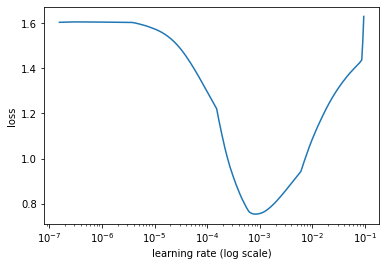

In [46]:
learner.lr_find(max_epochs=5)
learner.lr_plot()

The optimal learning rate is about $10^{-3}$. However as training is fast with GPU and to aid in more easily finding loss function minima, a lower learning rate of $10^{-4}$ is used.

In [78]:
history=learner.autofit(1e-4, epochs=10, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
84/84 [==============================] - 27s 231ms/step - loss: 0.6360 - accuracy: 0.8225 - val_loss: 0.1800 - val_accuracy: 0.9463
Epoch 2/10
84/84 [==============================] - 18s 213ms/step - loss: 0.1580 - accuracy: 0.9627 - val_loss: 0.1769 - val_accuracy: 0.9530
Epoch 3/10
84/84 [==============================] - 18s 216ms/step - loss: 0.0942 - accuracy: 0.9806 - val_loss: 0.1386 - val_accuracy: 0.9732
Epoch 4/10
84/84 [==============================] - 18s 214ms/step - loss: 0.0761 - accuracy: 0.9843 - val_loss: 0.1522 - val_accuracy: 0.9530
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Weights from best epoch have been loaded into model.


Early stopping ensures only a few epochs are needed as otherwise the training data would be overfit. 
The relatively small number of features makes training per epoch fast for deep learning. Training took under two minutes. The model appears to be quite accurate compared to our NMF benchmarks.

In [79]:
validation = learner.validate(val_data=val, print_report=True)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       1.00      0.96      0.98        27
           2       0.96      1.00      0.98        23
           3       1.00      1.00      1.00        39
           4       0.96      0.96      0.96        27

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149



The following code helps generate predictions but is also run on the training set to highlight the lengthy inference time and show an overall training accuracy to compare with NMF.

In [80]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

In [83]:
pipe(train['Text'][0])

[{'label': 'LABEL_0', 'score': 0.9903351068496704}]

In [84]:
start = time.time()
result_train = []
for i,j in enumerate(train['Text']):
    result_train.append((pipe(j))[0]['label'])
    #  Below is used to show progress
    if i%100 == 0:
        print(i)
end = time.time()
print(end - start)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
955.0346610546112


The above took more than 15 minutes. 

In [85]:
result_train[:10]

['LABEL_0',
 'LABEL_0',
 'LABEL_0',
 'LABEL_4',
 'LABEL_0',
 'LABEL_2',
 'LABEL_3',
 'LABEL_1',
 'LABEL_0',
 'LABEL_1']

The below code is used to convert the above output to the appropriate topic category strings.

In [86]:
label = []
preds_train = []
for i in result_train:
    for j in range(5):
        if i == "LABEL_" + str(j):
            label.append(j)
            preds_train.append(target_names[j])

preds_train[:10]

['business',
 'business',
 'business',
 'entertainment',
 'business',
 'politics',
 'sport',
 'tech',
 'business',
 'tech']

Now we can calculate the accuracy.

In [87]:
np.mean(train['Category'] == preds_train)

0.6375838926174496

Something appears amiss giving the metrics during training. The model has shuffled the "target_names" to be in alphabetical order.

In [93]:
label = []
preds_train = []
for i in result_train:
    for j in range(5):
        if i == "LABEL_" + str(j):
            label.append(j)
            preds_train.append(sorted(target_names)[j])

In [94]:
np.mean(train['Category'] == preds_train)

0.9885906040268456

The accuracy on the training data is very high, 0.989 (3 s.f.)

Our previously constructed "label_permute_compare" function confirms this. Note that sklearn's label-encoder was used which encodes strings in alphabetical order.

In [95]:
labelorder, acc = label_permute_compare(train['Category'], label)
print(labelorder, acc)

(0, 1, 2, 3, 4) 0.9885906040268456


The above shows the alphabetical ordering of "target names" is the correct permutation.

Now we generate predictions on the test set.

In [96]:
start = time.time()
result_test = []
for i,j in enumerate(test["Text"]):
    result_test.append((pipe(j))[0]['label'])
     #  Below is used to show progress
    if i%100 == 0:
        print(i)
end = time.time()
print(end - start)

0
100
200
300
400
500
600
700
518.4460899829865


The above code took over eight minutes to run.

In [97]:
preds_test = []
for i in result_test:
    for j in range(5):
        if i == "LABEL_" + str(j):
            preds_test.append(sorted(target_names)[j])

preds_test[:10]

['sport',
 'tech',
 'sport',
 'business',
 'sport',
 'sport',
 'politics',
 'politics',
 'entertainment',
 'business']

We now construct the submission file to get the test accuracy. 

In [98]:
sub2 = test.copy()
sub2['Category'] = preds_test
sub2.drop(columns = 'Text', inplace = True)
sub2.to_csv('submission_db.csv', index=False)
# Uncomment if wish to use for automatic notebook submission
# sub2.to_csv('submission.csv', index=False)

Test set accuracy for this run is 0.966 (3 s.f.). Another run with the same hyper-parameters gave a test set accuracy of 0.974 (3 s.f.). While these are slightly lower than the training accuracies, they are in line with the validation accuracies which show that overfitting is not an issue. This is the power of the sophisticated pre-trained transformer model used. This beats the best NMF benchmark test set accuracy of 0.943 (3 s.f).

However GPU's were needed and the time required to make inference was over eight minutes whereas all code for unsupervised NMF ran near instantaneously. All things considered NMF performed very well against a state of the art pre-trained model. Both managed well in not overfitting though Both managed well in not overfitting though utilizing a low number of features likely helped in the case of DistilBERT.

Re-running DistilBert with "maxlen" and "max_features" set as 300 instead of 200 and a validation set that was 20% of the data did not change performance. We now investigate whether using 20% of the data for training with the remainder as validation leads to a better performanceperformance for NMF or DistilBERT to see which is more data-efficient. 

In [100]:
from ktrain import text

t = text.Transformer('distilbert-base-uncased', maxlen=200, class_names = target_names)

In [101]:
train2, val, preprocess = texts_from_df(train, 'Text', label_columns=['Category'], val_df=None, max_features=200, val_pct = 0.8, maxlen=200, ngram_range=1, preprocess_mode='distilbert', verbose=1)

['business', 'entertainment', 'politics', 'sport', 'tech']
      business  entertainment  politics  sport  tech
464        0.0            0.0       1.0    0.0   0.0
728        1.0            0.0       0.0    0.0   0.0
281        0.0            0.0       0.0    0.0   1.0
1375       0.0            1.0       0.0    0.0   0.0
466        0.0            0.0       0.0    1.0   0.0
['business', 'entertainment', 'politics', 'sport', 'tech']
      business  entertainment  politics  sport  tech
520        0.0            1.0       0.0    0.0   0.0
432        0.0            0.0       0.0    1.0   0.0
1086       0.0            1.0       0.0    0.0   0.0
1009       0.0            0.0       1.0    0.0   0.0
504        0.0            0.0       0.0    1.0   0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 400
	95percentile : 739
	99percentile : 1063


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 381
	95percentile : 730
	99percentile : 922


In [102]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train2, val_data=val, batch_size=16)
history=learner.autofit(1e-4, epochs=10, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
19/19 [==============================] - 18s 556ms/step - loss: 1.2912 - accuracy: 0.5872 - val_loss: 0.7384 - val_accuracy: 0.8893
Epoch 2/10
19/19 [==============================] - 9s 482ms/step - loss: 0.4572 - accuracy: 0.9631 - val_loss: 0.2188 - val_accuracy: 0.9656
Epoch 3/10
19/19 [==============================] - 9s 485ms/step - loss: 0.1365 - accuracy: 0.9866 - val_loss: 0.1557 - val_accuracy: 0.9581
Epoch 4/10
19/19 [==============================] - 9s 478ms/step - loss: 0.0635 - accuracy: 0.9933 - val_loss: 0.1304 - val_accuracy: 0.9656
Epoch 5/10
19/19 [==============================] - 9s 478ms/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.1413 - val_accuracy: 0.9614
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping
Weights from best epoch have been loaded into model.


In [103]:
validation = learner.validate(val_data=val, print_report=True)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       264
           1       0.95      1.00      0.97       213
           2       0.96      0.94      0.95       221
           3       0.99      1.00      0.99       278
           4       0.95      0.95      0.95       216

    accuracy                           0.97      1192
   macro avg       0.96      0.97      0.96      1192
weighted avg       0.97      0.97      0.97      1192



DistilBERT still achieve's incredible accuracy with no perceptible drop in performance on the validation set even with only 20% of the data used for training. Other supervised learning algorithms likely may struggle comparatively.

In [149]:
 train3, val = train_test_split(train, train_size = 0.2, random_state = 0)

In [160]:
len(train3)

298

In [161]:
len(val)

1192

In [156]:
vect = TfidfVectorizer(min_df = 2, stop_words='english')
X = vect.fit_transform(train3['Text'])
model = NMF(n_components=5, 
            random_state=0,
            solver='mu', 
            beta_loss='kullback-leibler')

W = model.fit_transform(X)

nmf_acc_train(min_df=2, 
              solver='mu', 
              beta_loss='kullback-leibler')

((3, 2, 4, 1, 0), 0.9436241610738255)

In [157]:
labelorder = (3, 2, 4, 1, 0)
np.mean(nmf_test_preds(vect, model, labelorder, val['Text']) == val['Category'])

0.4463087248322148

Here NMF is overfitting on the 20% training data and not able to generalize on the 80% validation data with very poor validation test accuracy 0.446 (3.s.f.) Thus NMF is less data efficient and needs sufficient data to learn the latent components that match the training categories. This is not surprising given it is unsupervised and not leveraging the topic category labels.

## References

[1] Wikipedia "Stop word", https://en.wikipedia.org/wiki/Stop_word

[2] Wikipedia "Tf-idf", https://en.wikipedia.org/wiki/Tf%E2%80%93idf

[3] Sklearn documentation "TfidfTransformer", https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

[4] Sklearn documentation "TfidfVectorizer", https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

[5] Sklearn "Topic extraction with Non-negative Matrix Factorization ...", https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

[6] Dr. Vargo DistilBERT notebook, https://colab.research.google.com/drive/1_BygeRBggYuJ_gazfM-4ad4q9WxJWxqz
